# Imports

In [1]:
import numpy as np
import random
import sys, os
import cv2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
import keras.losses
import keras.optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Convolution2D, MaxPooling2D, Flatten, BatchNormalization
from keras.applications import MobileNetV2
from keras.preprocessing import image_dataset_from_directory
import subprocess, os, shutil

# Mounting drive

In [2]:
import subprocess, os, shutil
subprocess.run(['apt-get', 'install', 'unzip'])


CompletedProcess(args=['apt-get', 'install', 'unzip'], returncode=0)

In [3]:
#from google.colab import drive
#drive.mount('drive')
#shutil.copytree('./drive/My Drive/itl/itl_dataset', './itl_dataset')
for folder in ['itl_dataset', 'output_proper', 'output_bbox', 'output_proper', 'output_color']:
  if os.path.exists(folder):
    shutil.rmtree(folder)
print(os.getcwd())
VERSION=5
subprocess.run(['wget', f'http://students.mimuw.edu.pl/~mt406390/machine_learning/itl_dataset_v{VERSION}.zip'])
subprocess.run(['unzip', f'itl_dataset_v{VERSION}.zip'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

/content


CompletedProcess(args=['unzip', 'itl_dataset_v5.zip'], returncode=0, stdout=b'Archive:  itl_dataset_v5.zip\n   creating: output_bbox/\n  inflating: output_bbox/eq3106.png  \n  inflating: output_bbox/eq954.png   \n  inflating: output_bbox/eq5934.png  \n  inflating: output_bbox/eq5190.png  \n  inflating: output_bbox/eq4974.png  \n  inflating: output_bbox/eq3981.png  \n  inflating: output_bbox/eq3856.png  \n  inflating: output_bbox/eq3210.png  \n  inflating: output_bbox/eq1455.png  \n  inflating: output_bbox/eq3151.png  \n  inflating: output_bbox/eq4864.png  \n  inflating: output_bbox/eq2550.png  \n  inflating: output_bbox/eq2268.png  \n  inflating: output_bbox/eq4158.png  \n  inflating: output_bbox/eq2493.png  \n  inflating: output_bbox/eq5971.png  \n  inflating: output_bbox/eq2990.png  \n  inflating: output_bbox/eq2626.png  \n  inflating: output_bbox/eq1532.png  \n  inflating: output_bbox/eq1440.png  \n  inflating: output_bbox/eq4585.png  \n  inflating: output_bbox/eq5334.png  \n  infla

# Loading data

In [4]:
POINTS_PER_BOX=4
BBOXES=1
OUT_SIZE=POINTS_PER_BOX*BBOXES
INPUT_SHAPE=(224, 224, 1)

In [5]:
import json
with open('annotations.json', 'r') as flabels:
  annots = json.load(flabels)

In [6]:
dataset_size = len(annots)
print(dataset_size)
operators = np.zeros((dataset_size, OUT_SIZE))
print(operators.shape)
paths = [None] * dataset_size
for a in annots:
  idx = int(a['name'][len('eq') : a['name'].find('.')])
  operators[idx] = np.array(a['op'])
  paths[idx] = os.path.join('output_proper', a['name'])

6144
(6144, 4)


In [7]:
from google.colab.patches import cv2_imshow

def load_img(path):
  return 255-cv2.cvtColor(imread(path), cv2.COLOR_BGR2GRAY).reshape(INPUT_SHAPE)



In [9]:
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import math
from keras.utils import Sequence



class ITLSequence(Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        #batch_y = np.ones((self.batch_size, 4))*100
        return np.array([
            load_img(file_name) for file_name in batch_x], dtype=np.float64), batch_y

In [10]:
itlseq = ITLSequence(paths,operators, 64)

In [11]:
#help(Sequential.fit)


# Model


In [12]:
def get_model(verbose=False):
    model = Sequential()   
    model.add(keras.applications.MobileNetV2(weights=None, include_top=False, input_shape=INPUT_SHAPE)) 
    model.add(Conv2D(32, kernel_size=(5, 5), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(OUT_SIZE))

    if verbose:
      model.summary()

    model.compile('adadelta', 'mse')

    return model

def get_model_v2(verbose=False):
    model = Sequential()
    model.add(Conv2D(8, kernel_size=(5, 5), activation='relu', input_shape=INPUT_SHAPE))
    model.add(BatchNormalization())
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(OUT_SIZE))

    model.summary()
    model.compile('adadelta', 'mse')

    return model

In [13]:
print(INPUT_SHAPE)
mdl = get_model_v2()

(224, 224, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 8)       208       
_________________________________________________________________
batch_normalization (BatchNo (None, 220, 220, 8)       32        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 216, 216, 16)      3216      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 212, 212, 16)      6416      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 208, 208, 16)      6416      
_________________________________________________________________
flatten (Flatten)            (None, 692224)            0         
_________________________________________________________________
dropout (Dropout)            (None, 692224

In [14]:
mdl.fit(x=itlseq, batch_size=128, epochs=5)

Epoch 1/5
96/96 [==============================] - 14s 148ms/step - loss: 5086.4849
Epoch 2/5
96/96 [==============================] - 14s 150ms/step - loss: 1167.0499
Epoch 3/5
96/96 [==============================] - 14s 150ms/step - loss: 1010.7849
Epoch 4/5
96/96 [==============================] - 15s 152ms/step - loss: 857.1824
Epoch 5/5
96/96 [==============================] - 15s 153ms/step - loss: 740.2325


In [19]:
import cv2
from google.colab.patches import cv2_imshow
def visualize(path):
  infer = load_img(path)
  cv2img=load_img(path)
  cv2_imshow(cv2img)
  cv2img=cv2.cvtColor(cv2img, cv2.COLOR_GRAY2BGR)
  batch = np.zeros((1,*INPUT_SHAPE), dtype=np.float64)
  batch[0] = infer
  x,y,dx,dy=mdl.predict_on_batch(batch)[0]

  ox, oy, odx, ody = operators[idx]
  print(operators[idx])
  cv2.rectangle(cv2img, (int(x), int(y)), (int(x+dx), int(y+dy)), [0,0,255], 3)
  cv2.rectangle(cv2img, (int(ox), int(oy)), (int(ox+odx),int(oy+ody)), [0,255,0], 3)

  cv2_imshow(cv2img)
  print('Infer: ', x,y,dx,dy)
  print('Ori: ', ox, oy, odx, ody)




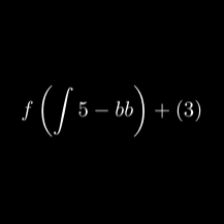

[ 26. 107.  10.  10.]


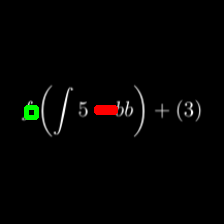

Infer:  96.08634 107.18155 19.399488 5.343314
Ori:  26.0 107.0 10.0 10.0


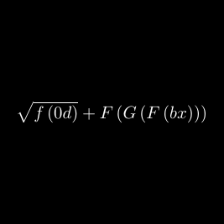

[ 26. 107.  10.  10.]


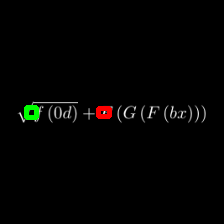

Infer:  98.34879 108.44203 11.358039 7.7274375
Ori:  26.0 107.0 10.0 10.0


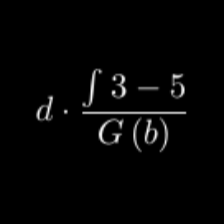

[ 26. 107.  10.  10.]


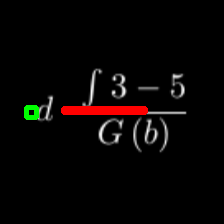

Infer:  63.675625 108.89366 82.160065 3.7663877
Ori:  26.0 107.0 10.0 10.0


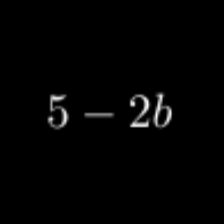

[ 26. 107.  10.  10.]


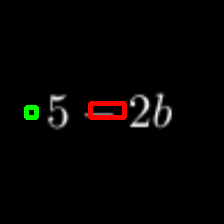

Infer:  90.735405 103.73027 34.13868 14.085326
Ori:  26.0 107.0 10.0 10.0


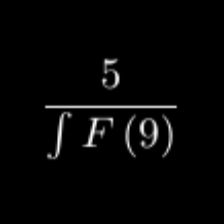

[ 26. 107.  10.  10.]


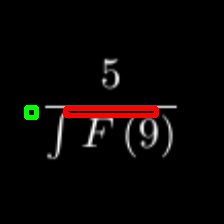

Infer:  65.70213 108.51135 90.649284 6.7242575
Ori:  26.0 107.0 10.0 10.0


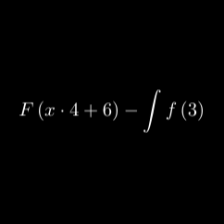

[ 26. 107.  10.  10.]


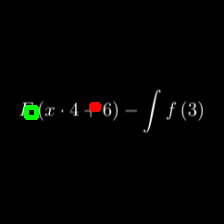

Infer:  91.92379 104.31935 6.3297706 4.8074512
Ori:  26.0 107.0 10.0 10.0


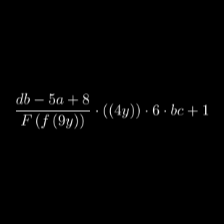

[ 26. 107.  10.  10.]


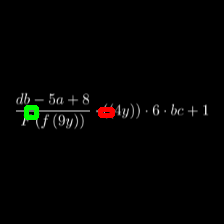

Infer:  100.59194 109.139046 12.1464815 6.376618
Ori:  26.0 107.0 10.0 10.0


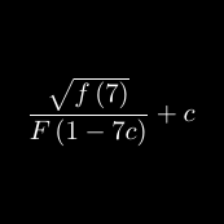

[ 26. 107.  10.  10.]


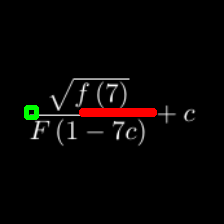

Infer:  81.288765 110.378716 72.847046 4.063414
Ori:  26.0 107.0 10.0 10.0


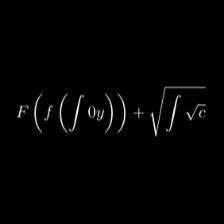

[ 26. 107.  10.  10.]


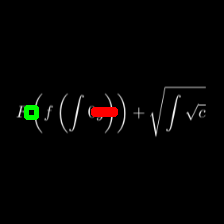

Infer:  93.194115 109.55739 22.721704 5.42573
Ori:  26.0 107.0 10.0 10.0


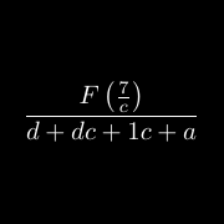

[ 26. 107.  10.  10.]


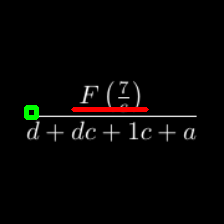

Infer:  73.61907 109.25998 73.201004 0.59598434
Ori:  26.0 107.0 10.0 10.0


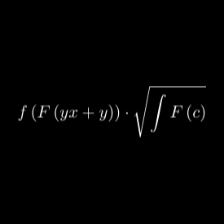

[ 26. 107.  10.  10.]


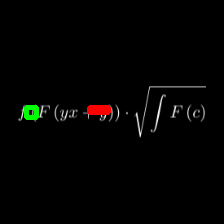

Infer:  89.81667 107.44065 18.582586 5.460765
Ori:  26.0 107.0 10.0 10.0


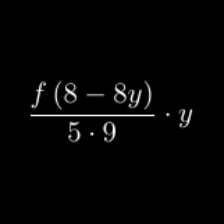

[ 26. 107.  10.  10.]


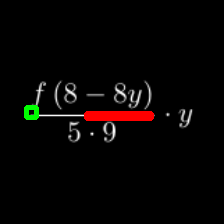

Infer:  86.30677 113.59881 64.75364 5.3263226
Ori:  26.0 107.0 10.0 10.0


In [20]:
for j in range(12):
  visualize(f'output_proper/eq{j}.png')